## Generating load scenarios using PGscen ##

In this notebook we will use PGscen to create demand scenarios for the load zones in the NYISO power grid. This can also be done using the command line tool ```pgscen-ny-load``` installed as part of PGscen.

In [1]:
start_date = '2019-02-25'
!pgscen-ny-load {start_date} 3 -vv

Creating NYISO scenarios for: 2019-02-25
Creating NYISO scenarios for: 2019-02-26
Creating NYISO scenarios for: 2019-02-27
Created 1000 load scenarios for 3 days in 4.9 seconds


Here we will go through and explain the steps carried out by the above tool in generating scenarios for a single day, as well as show some of the characteristics of the model that PGscen implements.

We begin by finding the folder in which input datasets are located, and where the output scenarios will be saved. We then choose the date for which scenarios will be generated. We normalize our data to UTC time, and our scenarios start at 6am UTC.

In [2]:
from pathlib import Path

cur_path = Path("nyiso_day_ahead_load.ipynb").parent.resolve()
data_dir = Path(cur_path, '..', "data", "NYISO").resolve()
print("The data folder we will use is: {}".format(data_dir))

import pandas as pd

scenario_count = 1000
scen_start_time = pd.to_datetime(' '.join([start_date, "06:00:00"]), utc=True)
print("Scenarios will start at: {}".format(scen_start_time))

The data folder we will use is: /Users/rcarmona/Princeton Dropbox/René Carmona/PGscen_Stuff/PGscen_4_Rana/PGscen/example/data/NYISO
Scenarios will start at: 2019-02-25 06:00:00+00:00


The next step is to load the actual demand observed for each load zone and the day-ahead forecasted demand. These two datasets are then split according to whether they came from before the day we want to generate scenarios for (```hist```) or during/after the scenario day (```futures```).

We will use all of the historical data to train the model, and the forecasts for the scenario day to generate new scenarios.

LOAD ACTUALS


,CAPITL,CENTRL,DUNWOD,GENESE,HUD VL,LONGIL,MHK VL,MILLWD,N.Y.C.,NORTH,WEST
Time,,,,,,,,,,,
2018-01-01 05:00:00+00:00,1609.3,2067.2,695.9,1152.2,1284.7,2596.1,1076.0,400.9,6073.3,664.0,1846.9
2018-01-01 06:00:00+00:00,1562.3,2024.2,668.0,1118.2,1228.1,2482.9,1041.8,394.8,5905.7,661.3,1794.2
2018-01-01 07:00:00+00:00,1540.9,1986.2,644.2,1091.1,1192.0,2384.0,1026.7,390.1,5744.7,654.4,1765.6
2018-01-01 08:00:00+00:00,1529.8,1958.1,619.6,1072.8,1190.7,2327.2,1016.1,377.4,5625.7,656.5,1763.7
2018-01-01 09:00:00+00:00,1528.9,1926.6,612.7,1072.7,1190.2,2309.9,1019.6,379.5,5572.0,660.0,1745.9



LOAD FORECASTS


,Issue_time,Forecast_time,CAPITL,CENTRL,DUNWOD,GENESE,HUD VL,LONGIL,MHK VL,MILLWD,N.Y.C.,NORTH,WEST
0,2017-12-31 18:00:00+00:00,2018-01-01 06:00:00+00:00,1468,1746,697,978,1125,2346,843,340,5540,617,1669
1,2017-12-31 18:00:00+00:00,2018-01-01 07:00:00+00:00,1437,1701,678,949,1094,2256,823,333,5391,615,1630
2,2017-12-31 18:00:00+00:00,2018-01-01 08:00:00+00:00,1431,1696,664,940,1080,2204,821,324,5268,616,1616
3,2017-12-31 18:00:00+00:00,2018-01-01 09:00:00+00:00,1441,1721,661,953,1084,2192,833,322,5220,620,1620
4,2017-12-31 18:00:00+00:00,2018-01-01 10:00:00+00:00,1469,1756,676,978,1102,2208,846,330,5259,632,1643


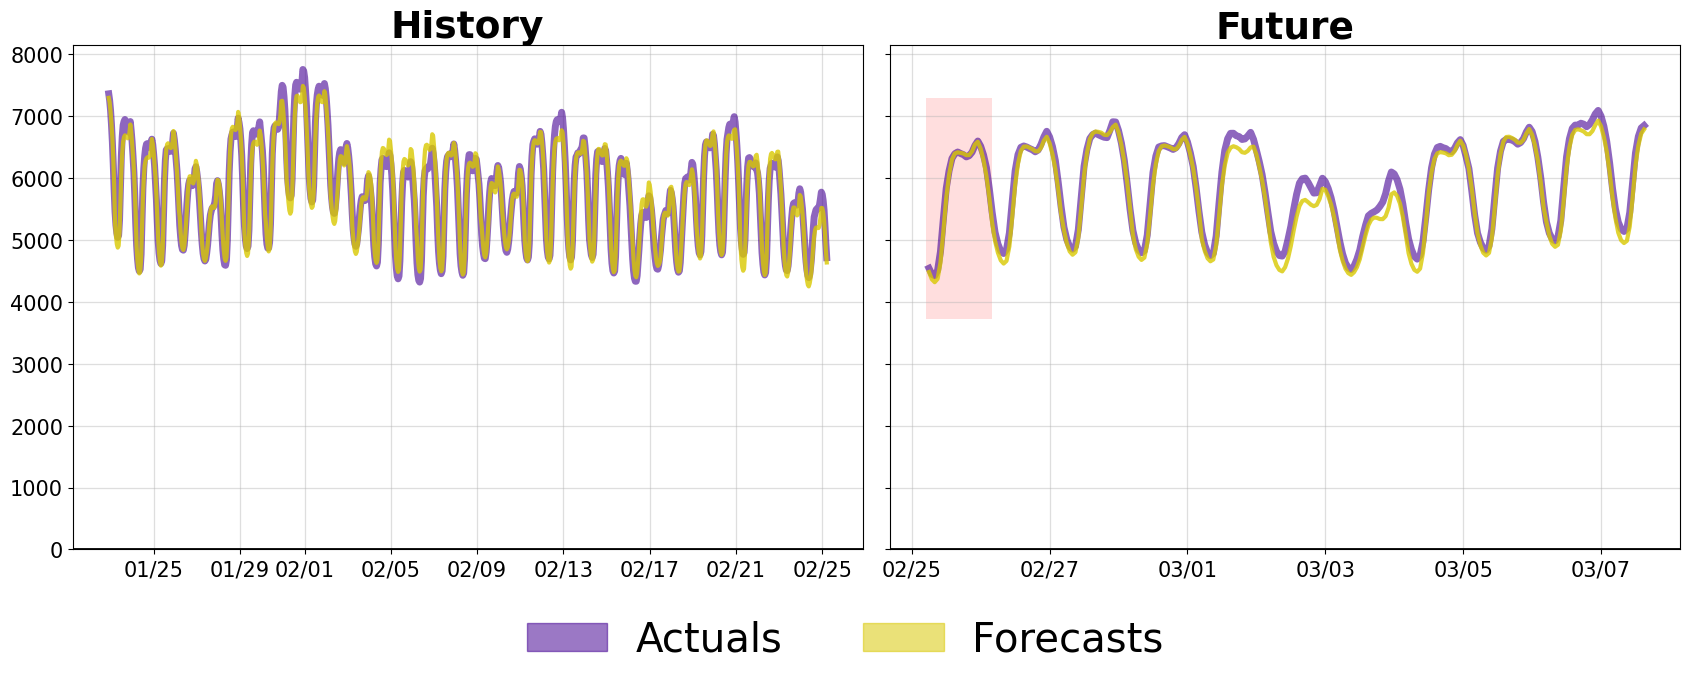

In [4]:
from pgscen.utils.data_utils import (
    load_ny_load_data, split_actuals_hist_future, split_forecasts_hist_future)
from IPython.display import display


scen_timesteps = pd.date_range(start=scen_start_time, periods=24, freq='H')

load_zone_actual_df, load_zone_forecast_df = load_ny_load_data()

(load_zone_actual_hists,
     load_zone_actual_futures) = split_actuals_hist_future(
            load_zone_actual_df, scen_timesteps)

(load_zone_forecast_hists,
     load_zone_forecast_futures) = split_forecasts_hist_future(
            load_zone_forecast_df, scen_timesteps)

print("LOAD ACTUALS")
display(load_zone_actual_df.iloc[:5, :].round(1))
print("")
print("LOAD FORECASTS")
display(load_zone_forecast_df.iloc[:5, :].round(1))
print("")

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

%matplotlib inline
plt.rcParams['figure.figsize'] = [19, 11]

fig, (hist_ax, future_ax) = plt.subplots(figsize=(17, 6),
                                         nrows=1, ncols=2, sharey=True)

title_args = dict(weight='semibold', size=27)
actual_clr, fcst_clr = "#430093", "#D9C800"
plt_asset = 'N.Y.C.'

hist_ax.set_title("History", **title_args)
hist_ax.plot(load_zone_actual_hists[plt_asset][-800:],
             c=actual_clr, lw=5, alpha=0.6)
hist_ax.plot(load_zone_forecast_hists['Forecast_time'][-800:],
             load_zone_forecast_hists[plt_asset][-800:],
             c=fcst_clr, lw=3, alpha=0.8)

future_ax.set_title("Future", **title_args)
future_ax.plot(load_zone_actual_futures[plt_asset][:250],
               c=actual_clr, lw=5, alpha=0.6)
future_ax.plot(load_zone_forecast_futures['Forecast_time'][:250],
               load_zone_forecast_futures[plt_asset][:250],
               c=fcst_clr, lw=3, alpha=0.8)

future_ax.fill_between(load_zone_actual_futures.index[:24] - pd.Timedelta(hours=1),
                       load_zone_actual_futures[plt_asset][:24].min() - 700,
                       load_zone_actual_futures[plt_asset][:24].max() + 700,
                       facecolor='red', edgecolor='none', alpha=0.13)

for ax in [hist_ax, future_ax]:
    ax.tick_params(which='both', labelsize=15)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax.grid(linewidth=0.9, alpha=0.41)
    ax.axhline(0, lw=1.3, c='black', alpha=1)
    ax.set_ylim((0, ax.get_ylim()[1]))

lgnd_ptchs = [Patch(color=actual_clr, alpha=0.53, label="Actuals"),
              Patch(color=fcst_clr, alpha=0.53, label="Forecasts")]

_ = fig.legend(handles=lgnd_ptchs, frameon=False, fontsize=29, ncol=2, loc=8,
               bbox_to_anchor=(0.5, -0.17), handletextpad=0.7)
fig.tight_layout(w_pad=1)

We use the historical data to train our scenario GEMINI model, which is handled by our scenario engine. This model will fit a covariance matrix for the set of assets (in this case, load zones), and another covariance matrix for the set of time points for the day.

In [5]:
from pgscen.engine import GeminiEngine

ge = GeminiEngine(load_zone_actual_hists, load_zone_forecast_hists,
                  scen_start_time, asset_type='load')
ge.fit(asset_rho=0.05, horizon_rho=0.05)

display(ge.model.asset_cov.round(3))
display(ge.model.horizon_cov.iloc[:11, :11].round(3))

,CAPITL,CENTRL,DUNWOD,GENESE,HUD VL,LONGIL,MHK VL,MILLWD,N.Y.C.,NORTH,WEST
CAPITL,1.475,0.566,0.395,0.461,0.755,0.447,0.577,0.352,0.433,0.147,0.256
CENTRL,0.566,1.475,0.306,0.821,0.512,0.410,0.661,0.375,0.419,0.164,0.455
DUNWOD,0.395,0.306,1.475,0.292,0.717,0.719,0.263,0.376,0.647,0.066,0.173
GENESE,0.461,0.821,0.292,1.475,0.438,0.434,0.421,0.299,0.415,0.204,0.679
HUD VL,0.755,0.512,0.717,0.438,1.475,0.775,0.470,0.554,0.741,0.112,0.270
LONGIL,0.447,0.410,0.719,0.434,0.775,1.475,0.327,0.547,0.903,0.088,0.252
MHK VL,0.577,0.661,0.263,0.421,0.470,0.327,1.475,0.365,0.327,0.159,0.235
MILLWD,0.352,0.375,0.376,0.299,0.554,0.547,0.365,1.475,0.572,0.071,0.173
N.Y.C.,0.433,0.419,0.647,0.415,0.741,0.903,0.327,0.572,1.475,0.085,0.235
NORTH,0.147,0.164,0.066,0.204,0.112,0.088,0.159,0.071,0.085,1.475,0.099


,lag_0,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
lag_0,0.677,0.623,0.601,0.573,0.522,0.467,0.420,0.374,0.340,0.318,0.302
lag_1,0.623,0.677,0.624,0.599,0.544,0.484,0.434,0.385,0.349,0.327,0.310
lag_2,0.601,0.624,0.677,0.619,0.565,0.502,0.448,0.397,0.360,0.336,0.319
lag_3,0.573,0.599,0.619,0.677,0.601,0.532,0.472,0.417,0.377,0.352,0.333
lag_4,0.522,0.544,0.565,0.601,0.676,0.592,0.520,0.456,0.410,0.380,0.359
lag_5,0.467,0.484,0.502,0.532,0.592,0.676,0.589,0.511,0.458,0.423,0.397
lag_6,0.420,0.434,0.448,0.472,0.520,0.589,0.676,0.584,0.521,0.479,0.447
lag_7,0.374,0.385,0.397,0.417,0.456,0.511,0.584,0.676,0.599,0.548,0.510
lag_8,0.340,0.349,0.360,0.377,0.410,0.458,0.521,0.599,0.676,0.607,0.564
lag_9,0.318,0.327,0.336,0.352,0.380,0.423,0.479,0.548,0.607,0.676,0.613


We see, for example, that using a stronger regularization penalty for our LASSO model when fitting the model results in sparser covariance matrices. These covariances can be in turn used to calculate partial correlations between each pair of assets and time points to produce graphical representations.

In [6]:
import seaborn as sns
import numpy as np
from ipywidgets import interact, FloatText
from pgscen.utils.plot_utils import get_clustermat, cov_cmap
import networkx as nx
from itertools import combinations as combn


def draw_pcor_graph(pcor_mat, asset_list, ax, plt_thresh, **nxargs):
    asset_graph = nx.Graph()

    for (i, asset1), (j, asset2) in combn(enumerate(asset_list), 2):
        if np.abs(pcor_mat[i, j]) >= plt_thresh:
            asset_graph.add_edge(asset1, asset2, pcor=pcor_mat[i, j])
    
    nx.draw(asset_graph, ax=ax, with_labels=True, 
            node_color='green', font_weight='bold',
            edge_color=[(0.10, 0.37, 1., 0.47) if val > 0 else (1., 0., 0., 0.47)
                        for val in nx.get_edge_attributes(asset_graph, 'pcor').values()],
            width=[53 * (val - plt_thresh)
                   for val in nx.get_edge_attributes(asset_graph, 'pcor').values()],
            **nxargs)

def plot_zone_covars(rho):
    ge.fit(asset_rho=rho, horizon_rho=rho)

    fig, axarr = plt.subplots(figsize=(15, 12), nrows=2, ncols=2)
    asset_clust = get_clustermat(ge.model.asset_cov)
    asset_var = asset_clust.iloc[0, 0]
    time_clust = get_clustermat(ge.model.horizon_cov)
    time_var = time_clust.iloc[0, 0]

    sns.heatmap(asset_clust, ax=axarr[0, 0],
                cmap=cov_cmap, vmin=-asset_var, vmax=asset_var, square=True)
    sns.heatmap(time_clust, ax=axarr[0, 1],
                cmap=cov_cmap, vmin=-time_var, vmax=time_var, square=True)

    asset_lbls = [asset.replace('_', ' ') for asset in asset_clust.index]
    axarr[0, 0].set_xticklabels(asset_lbls,
                                rotation=31, ha='right', size=17)
    axarr[0, 0].set_yticklabels(asset_lbls, size=17)

    time_lbls = [ge.scen_timesteps[int(lag.split('_')[1])].strftime("%H:%M")
                 for lag in time_clust.index]
    axarr[0, 1].set_xticklabels(time_lbls, rotation=90, size=13)
    axarr[0, 1].set_yticklabels(time_lbls, size=13)

    axarr[0, 0].set_title("Load Covariance\n", **title_args)
    axarr[0, 1].set_title("Timestep Covariance\n", **title_args)
    
    asset_prec = np.linalg.inv(ge.model.asset_cov)
    asset_pcor = -asset_prec / np.sqrt(np.outer(np.diag(asset_prec),
                                                np.diag(asset_prec)))
    draw_pcor_graph(asset_pcor, ge.asset_list, axarr[1, 0], 0.05, font_size=17)
    
    time_lbls = [ge.scen_timesteps[int(lag.split('_')[1])].strftime("%H")
                 for lag in ge.model.horizon_cov.index]
    time_prec = np.linalg.inv(ge.model.horizon_cov)
    time_pcor = -time_prec / np.sqrt(np.outer(np.diag(time_prec),
                                              np.diag(time_prec)))
    draw_pcor_graph(time_pcor, time_lbls, axarr[1, 1], 0.2, font_size=13)
    
    fig.tight_layout(w_pad=7)    

w = FloatText(value=0.05,
              layout={'align_self': 'center'}, style={'description_width': 'initial'},
              disabled=False)
_ = interact(plot_zone_covars, rho=w)

interactive(children=(FloatText(value=0.05, description='rho', layout=Layout(align_self='center'), style=Descr…

We can now use this fitted model to produce scenarios. This is done by producing deviations from the forecasted data for the given day using the distributions whose parameters were determined during the fitting step.

In [7]:
ge.create_scenario(scenario_count, load_zone_forecast_futures,
                   bin_width_ratio=0.1, min_sample_size=400)

display(ge.scenarios['load']['N.Y.C.'].round(1))

,2019-02-25 06:00:00+00:00,2019-02-25 07:00:00+00:00,2019-02-25 08:00:00+00:00,2019-02-25 09:00:00+00:00,2019-02-25 10:00:00+00:00,2019-02-25 11:00:00+00:00,2019-02-25 12:00:00+00:00,2019-02-25 13:00:00+00:00,2019-02-25 14:00:00+00:00,2019-02-25 15:00:00+00:00,...,2019-02-25 20:00:00+00:00,2019-02-25 21:00:00+00:00,2019-02-25 22:00:00+00:00,2019-02-25 23:00:00+00:00,2019-02-26 00:00:00+00:00,2019-02-26 01:00:00+00:00,2019-02-26 02:00:00+00:00,2019-02-26 03:00:00+00:00,2019-02-26 04:00:00+00:00,2019-02-26 05:00:00+00:00
0,4554.2,4433.3,4460.9,4421.7,4796.0,5291.3,5852.6,6076.7,6334.4,6486.5,...,6488.9,6637.8,6748.1,6627.5,6511.7,6359.4,6078.0,5803.1,5484.2,5043.3
1,4301.2,4147.4,4217.5,4240.6,4630.5,5214.5,5756.0,6164.7,6422.5,6500.3,...,6675.0,6978.8,7089.8,7277.3,6826.8,6605.7,6450.1,6030.4,5438.1,5090.6
2,4447.8,4303.3,4217.2,4127.0,4483.5,5003.0,5545.5,6103.9,6450.0,6539.9,...,6507.0,6568.5,6663.5,6627.7,6469.5,6316.9,6057.2,5617.5,5237.1,4949.7
3,4505.2,4395.9,4391.4,4441.5,4668.0,5182.2,5699.3,6131.0,6349.7,6517.7,...,6482.2,6593.7,6582.5,6628.4,6396.2,6280.6,6038.2,5672.8,5330.4,4962.6
4,4434.8,4181.7,4198.5,4181.0,4519.1,4906.7,5538.1,5755.8,6139.9,6293.2,...,6406.9,6492.2,6576.0,6526.5,6356.0,6253.3,5947.4,5493.4,5207.6,4998.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,4394.7,4353.6,4345.7,4405.4,4599.7,5027.7,5706.2,6057.8,6384.8,6507.3,...,6512.9,6514.5,6608.9,6593.8,6462.2,6301.3,6097.0,5719.1,5208.4,4895.5
996,4401.4,4267.1,4155.0,4239.6,4524.4,4853.9,5425.0,6040.5,6279.3,6481.5,...,6297.1,6441.7,6502.2,6547.5,6351.5,6146.7,6037.9,5476.4,4710.6,4716.4
997,4529.0,4354.6,4376.4,4419.8,4648.3,5177.6,5748.8,6020.7,6325.4,6319.0,...,6538.3,6567.6,6540.8,6591.9,6567.5,6367.4,5998.3,5773.1,5639.9,5170.8
998,4538.5,4424.9,4334.8,4454.1,4756.7,5323.9,5856.9,6221.2,6448.6,6620.2,...,6403.1,6529.3,6581.7,6676.0,6579.0,6371.3,6076.8,5812.9,5338.7,5050.3


In [8]:
from ipywidgets import Dropdown


def plot_zone_scenarios(plt_zone):
    fig, ax = plt.subplots(figsize=(15, 7))

    for i in range(scenario_count):
        plt.plot(ge.scenarios['load'].iloc[i][plt_zone],
                 c='black', alpha=0.13, lw=0.2)

    plt_fcst = ge.forecasts['load'][plt_zone]
    plt.plot(plt_fcst, c=fcst_clr, alpha=0.47, lw=4.1)
    plt.plot(load_zone_actual_futures.loc[plt_fcst.index, plt_zone],
             c=actual_clr, alpha=0.47, lw=4.1)

    quant_df = ge.scenarios['load'][plt_zone].quantile([0.25, 0.75])
    ax.fill_between(quant_df.columns, quant_df.iloc[0], quant_df.iloc[1],
                    color='red', alpha=0.31)

    ax.tick_params(which='both', labelsize=15)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d %Hh'))
    ax.grid(linewidth=0.9, alpha=0.41)
    ax.axhline(0, lw=1.3, c='black', alpha=1)
    ax.set_ylim((0, ax.get_ylim()[1]))
    
    lgnd_ptchs = [Patch(color='black', alpha=0.23, label="Scenarios"),
                  Patch(color='red', alpha=0.41, label="Interquartile Range"),
                  Patch(color=fcst_clr, alpha=0.81, label="Forecast"),
                  Patch(color=actual_clr, alpha=0.81, label="Actual")]

    _ = plt.legend(handles=lgnd_ptchs, frameon=False, fontsize=17, ncol=4, loc=8,
                   bbox_to_anchor=(0.5, -0.17), handletextpad=0.7)

w = Dropdown(options=ge.asset_list, description="Scenarios for zone:",
             layout={'align_self': 'center'}, style={'description_width': 'initial'},
             disabled=False)
_ = interact(plot_zone_scenarios, plt_zone=w)

interactive(children=(Dropdown(description='Scenarios for zone:', layout=Layout(align_self='center'), options=…

Our final step is to save the generated scenarios to file. We include the actual and forecasted load demands in the saved data to facilitate downstream analyses.

In [ ]:
ge.write_to_csv(data_dir, load_zone_actual_futures, write_forecasts=True)
!ls {data_dir}/{start_date.replace('-', '')}/load